In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
import sklearn
import regex as re
import matplotlib.patches as mpatches
import matplotlib.patches as patches



# Data Cleaning

In [2]:
means = pd.read_csv("cofactor_expression/mean_expression.csv").set_index("tissueSiteDetailId").T
medians = pd.read_csv("cofactor_expression/median_expression.csv").set_index("tissueSiteDetailId").T
stds = pd.read_csv("cofactor_expression/std_expression.csv").set_index("tissueSiteDetailId").T
counts = pd.read_csv("cofactor_expression/counts_expression.csv").set_index("tissueSiteDetailId")
GTEXmapper = pd.read_csv("helperfiles/mapper_GTEXcode.csv")
cofactors = pd.read_csv("helperfiles/cofactors_mapped_combined.csv")

In [3]:
#Remove tissues where sample count < 100
tissues_less100 = counts[counts["ENSG00000156603.15"] < 100].index.to_list()
medians = medians.drop(tissues_less100, axis=1)
means = means.drop(tissues_less100, axis=1)

In [4]:
#Remove sex-specific, disease-specific tissues
removetissues = ["Breast_Mammary_Tissue", "Testis", "Prostate", "Uterus", "Ovary", "Vagina", "Skin_Not_Sun_Exposed_Suprapubic", "Cells_EBV-transformed_lymphocytes", "Skin_Sun_Exposed_Lower_leg"]
medians = medians.drop(removetissues, axis=1)
means = means.drop(removetissues, axis=1)

In [5]:
#Merged DF of genes
cofactors_select = cofactors[["Gene Name", "Complex", "Subcomplex or Module", "UniprotID", "Own-complex paralog"]]
merged = cofactors_select.merge(GTEXmapper, on="UniprotID")
merged.head()

,Gene Name,Complex,Subcomplex or Module,UniprotID,Own-complex paralog,Bgee,GeneID,Gene Names,GTEXGeneCode
0,BAF180,BAF,esBAF,Q86U86,NaN,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
1,BAF180,BAF,npBAF,Q86U86,NaN,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
2,BAF180,BAF,nBAF,Q86U86,NaN,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
3,BCL11A,BAF,esBAF,Q9H165,[BCL11B],ENSG00000119866,53335.0,"['BCL11A', 'CTIP1', 'EVI9', 'KIAA1809', 'ZNF856']",ENSG00000119866.20
4,BCL11A,BAF,npBAF,Q9H165,[BCL11B],ENSG00000119866,53335.0,"['BCL11A', 'CTIP1', 'EVI9', 'KIAA1809', 'ZNF856']",ENSG00000119866.20


In [6]:
#Identifying genes with multiple entries due to gene name redundancy
GTEXmappermain = merged[["GTEXGeneCode", "Gene Name", "Complex", "Subcomplex or Module"]]
grouped = GTEXmappermain.groupby("GTEXGeneCode").agg(list)
grouped_count = GTEXmappermain.groupby("GTEXGeneCode").agg(len)
grouped[grouped_count["Gene Name"] > 1]

GTEXmappermain = merged[["GTEXGeneCode", "Gene Name", "Complex", "Subcomplex or Module", "Own-complex paralog"]]
grouped = GTEXmappermain.groupby("GTEXGeneCode").agg(lambda x: list(set(x.to_list())))
grouped["Gene Name"] = grouped["Gene Name"].apply(lambda x: x[0])

def flatten_and_clean(input_list):
    output_list = []
    
    for item in input_list:
        # If the item is a list, recursively flatten it
        if isinstance(item, list):
            output_list.extend(flatten_and_clean(item))  # Recursion to flatten sublists
        # If the item is NaN, skip it
        elif isinstance(item, float) and math.isnan(item):
            continue
        else:
            output_list.append(item.replace("[", "").replace("]", ""))
        
    return output_list

grouped["Subcomplex or Module"] = grouped["Subcomplex or Module"].apply(flatten_and_clean)



In [7]:
#Log transform of mean, medians
genename = grouped[["Gene Name"]]
medians_gene = np.log(medians.merge(genename, left_index=True, right_index=True).set_index("Gene Name"))
means_gene = np.log(means.merge(genename, left_index=True, right_index=True).set_index("Gene Name"))
stds_gene = stds.merge(genename, left_index=True, right_index=True).set_index("Gene Name")

In [8]:
#Normalize across DFs
def z_score(col):
    return (col - np.mean(col))/np.std(col)

medians_gene = medians_gene.apply(z_score, axis=1)
means_gene = means_gene.apply(z_score, axis=1)


In [9]:
#Sort columns and rows highest to lowest
medians_gene["Net"] = medians_gene.sum(axis=1)
medians_gene = medians_gene.sort_values("Net").drop("Net", axis = 1)
medians_gene.head()

,Thyroid,Small_Intestine_Terminal_Ileum,Brain_Frontal_Cortex_BA9,Whole_Blood,Brain_Amygdala,Pituitary,Minor_Salivary_Gland,Adipose_Subcutaneous,Adrenal_Gland,Heart_Atrial_Appendage,...,Brain_Spinal_cord_cervical_c-1,Adipose_Visceral_Omentum,Brain_Nucleus_accumbens_basal_ganglia,Brain_Cerebellar_Hemisphere,Esophagus_Mucosa,Cells_Cultured_fibroblasts,Artery_Aorta,Brain_Putamen_basal_ganglia,Lung,Brain_Substantia_nigra
Gene Name,,,,,,,,,,,,,,,,,,,,,
POLR2J,1.520986,-0.311215,-0.732422,-0.485303,-0.484944,1.591619,-0.421683,-0.004750,1.175211,-0.331562,...,0.480370,-0.059510,-0.304469,0.565753,-0.140341,1.396771,1.165636,-0.973957,0.034685,-0.195850
TADA3,1.354327,0.049176,0.307937,0.879286,-0.364463,1.406624,-0.448723,0.120006,1.250399,-1.200305,...,-0.746097,-0.179062,-0.404354,-0.755882,-0.472035,1.132177,1.468020,-0.690558,0.744660,-0.747207
SMARCB1,1.237138,1.102116,0.035124,-1.575851,-0.873226,1.243538,0.466691,0.325056,0.359740,-1.025968,...,-0.221480,0.054708,-0.500802,2.177220,0.625384,1.741245,0.255880,-1.037076,0.398373,-0.890265
KAT2A,1.543365,0.386956,0.121984,-3.027449,-0.982455,1.142073,-0.486404,0.498362,1.268456,-0.936637,...,-0.506460,0.895408,-0.533213,1.196140,0.001147,-0.874869,0.309758,-0.869747,0.319108,-0.856139
TAF10,1.363328,0.232273,-0.556336,1.645340,-0.318751,1.685474,-0.047284,0.249894,1.602458,-0.839048,...,0.401227,0.466649,-0.758845,-2.148907,0.811878,1.952934,0.101747,-0.937334,1.275483,-0.257157


In [10]:
medians_gene = medians_gene.T
medians_gene["Net"] = medians_gene.sum(axis=1)
medians_gene = medians_gene.sort_values("Net").drop("Net", axis = 1)
medians_gene = medians_gene.T
medians_gene.head()

,Heart_Left_Ventricle,Pancreas,Liver,Whole_Blood,Brain_Putamen_basal_ganglia,Brain_Amygdala,Heart_Atrial_Appendage,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Colon_Sigmoid,Lung,Artery_Aorta,Pituitary,Brain_Cerebellum,Artery_Tibial,Brain_Cerebellar_Hemisphere,Thyroid,Cells_Cultured_fibroblasts,Nerve_Tibial
Gene Name,,,,,,,,,,,,,,,,,,,,,
POLR2J,-0.885161,-3.707782,-1.225929,-0.485303,-0.973957,-0.484944,-0.331562,-0.195850,-0.983374,-0.553682,...,0.631342,0.034685,1.165636,1.591619,0.286566,0.643983,0.565753,1.520986,1.396771,0.513127
TADA3,-2.135875,-3.232682,-1.396374,0.879286,-0.690558,-0.364463,-1.200305,-0.747207,-0.573727,-0.318817,...,1.080154,0.744660,1.468020,1.406624,-0.529809,0.982902,-0.755882,1.354327,1.132177,1.158430
SMARCB1,-1.739571,-1.602945,-1.901382,-1.575851,-1.037076,-0.873226,-1.025968,-0.890265,-0.997048,-0.673939,...,0.035954,0.398373,0.255880,1.243538,2.112446,0.486949,2.177220,1.237138,1.741245,1.068829
KAT2A,-1.928467,-0.949680,-0.604795,-3.027449,-0.869747,-0.982455,-0.936637,-0.856139,-0.727499,-0.525891,...,1.062249,0.319108,0.309758,1.142073,1.540602,-0.273080,1.196140,1.543365,-0.874869,1.776086
TAF10,-1.457643,-0.371076,-0.389736,1.645340,-0.937334,-0.318751,-0.839048,-0.257157,-0.408861,-0.837241,...,0.206982,1.275483,0.101747,1.685474,-2.052060,-0.531483,-2.148907,1.363328,1.952934,0.605585


# Cluster Maps

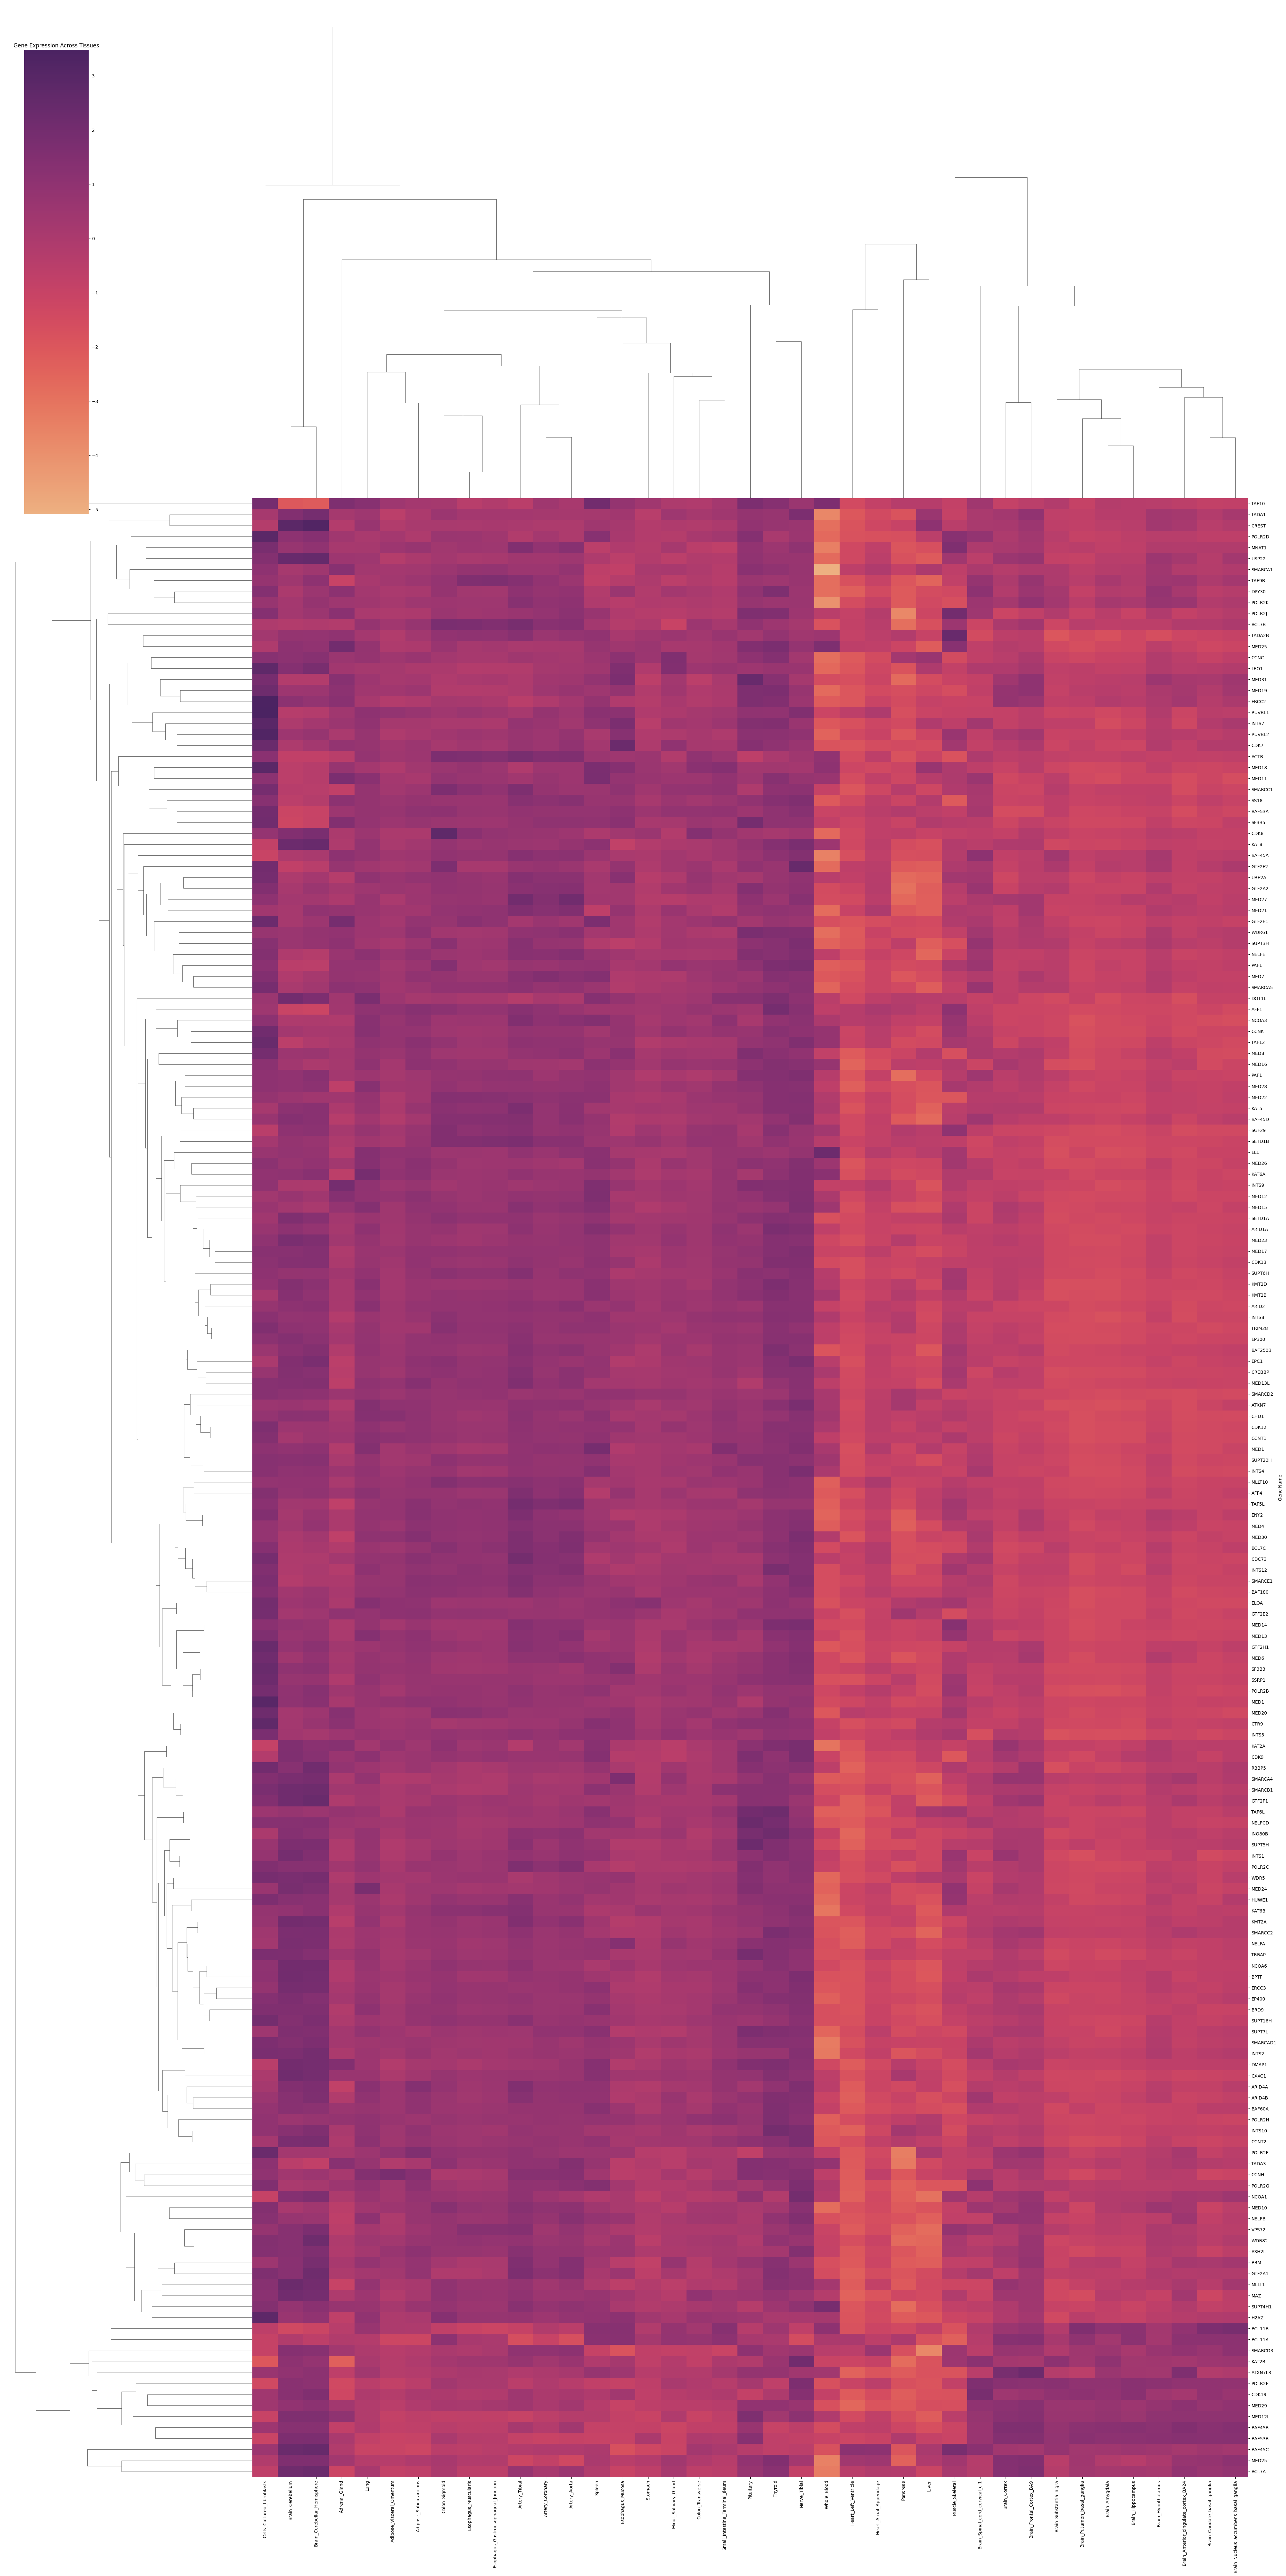

In [11]:
sns.clustermap(medians_gene, figsize=(40, 80), cmap="flare")
plt.title("Gene Expression Across Tissues")
plt.savefig("figures/normalized/mediangeneexpression.png")

In [42]:
%%script echo
sns.clustermap(means_gene, figsize=(40, 80), cmap = "flare")
plt.title("Mean Gene Expression Across Tissues")
plt.savefig("figures/normalized/meangeneexpression.png")

In [13]:
#Some genes are in multiple complexes (due to more generic classification in "other.csv") -- this ensures each complex is only in one complex
multicomplex = grouped[[len(complex) > 1 for complex in grouped["Complex"]]]
grouped_single_complex = grouped.copy()[["Gene Name", "Complex"]]
grouped_single_complex.loc[multicomplex.index.to_list(), "Complex"] = multicomplex["Complex"].apply(lambda x: x[1])
grouped_single_complex["Complex"] = [val[0] if (isinstance(val, list) or isinstance(val, pd.Series)) else val for val in grouped_single_complex["Complex"]]
grouped_single_complex = grouped_single_complex.drop_duplicates()
grouped_single_complex = grouped_single_complex.set_index("Gene Name")


def get_one_complex(genename):
    return grouped_single_complex.loc[genename]["Complex"]

grouped_single_complex.head()

,Complex
Gene Name,
POLR2J,RNA Pol II
CREBBP,P300-CBP
PAF1,Elongation
MED24,Mediator
ELOA,Elongation


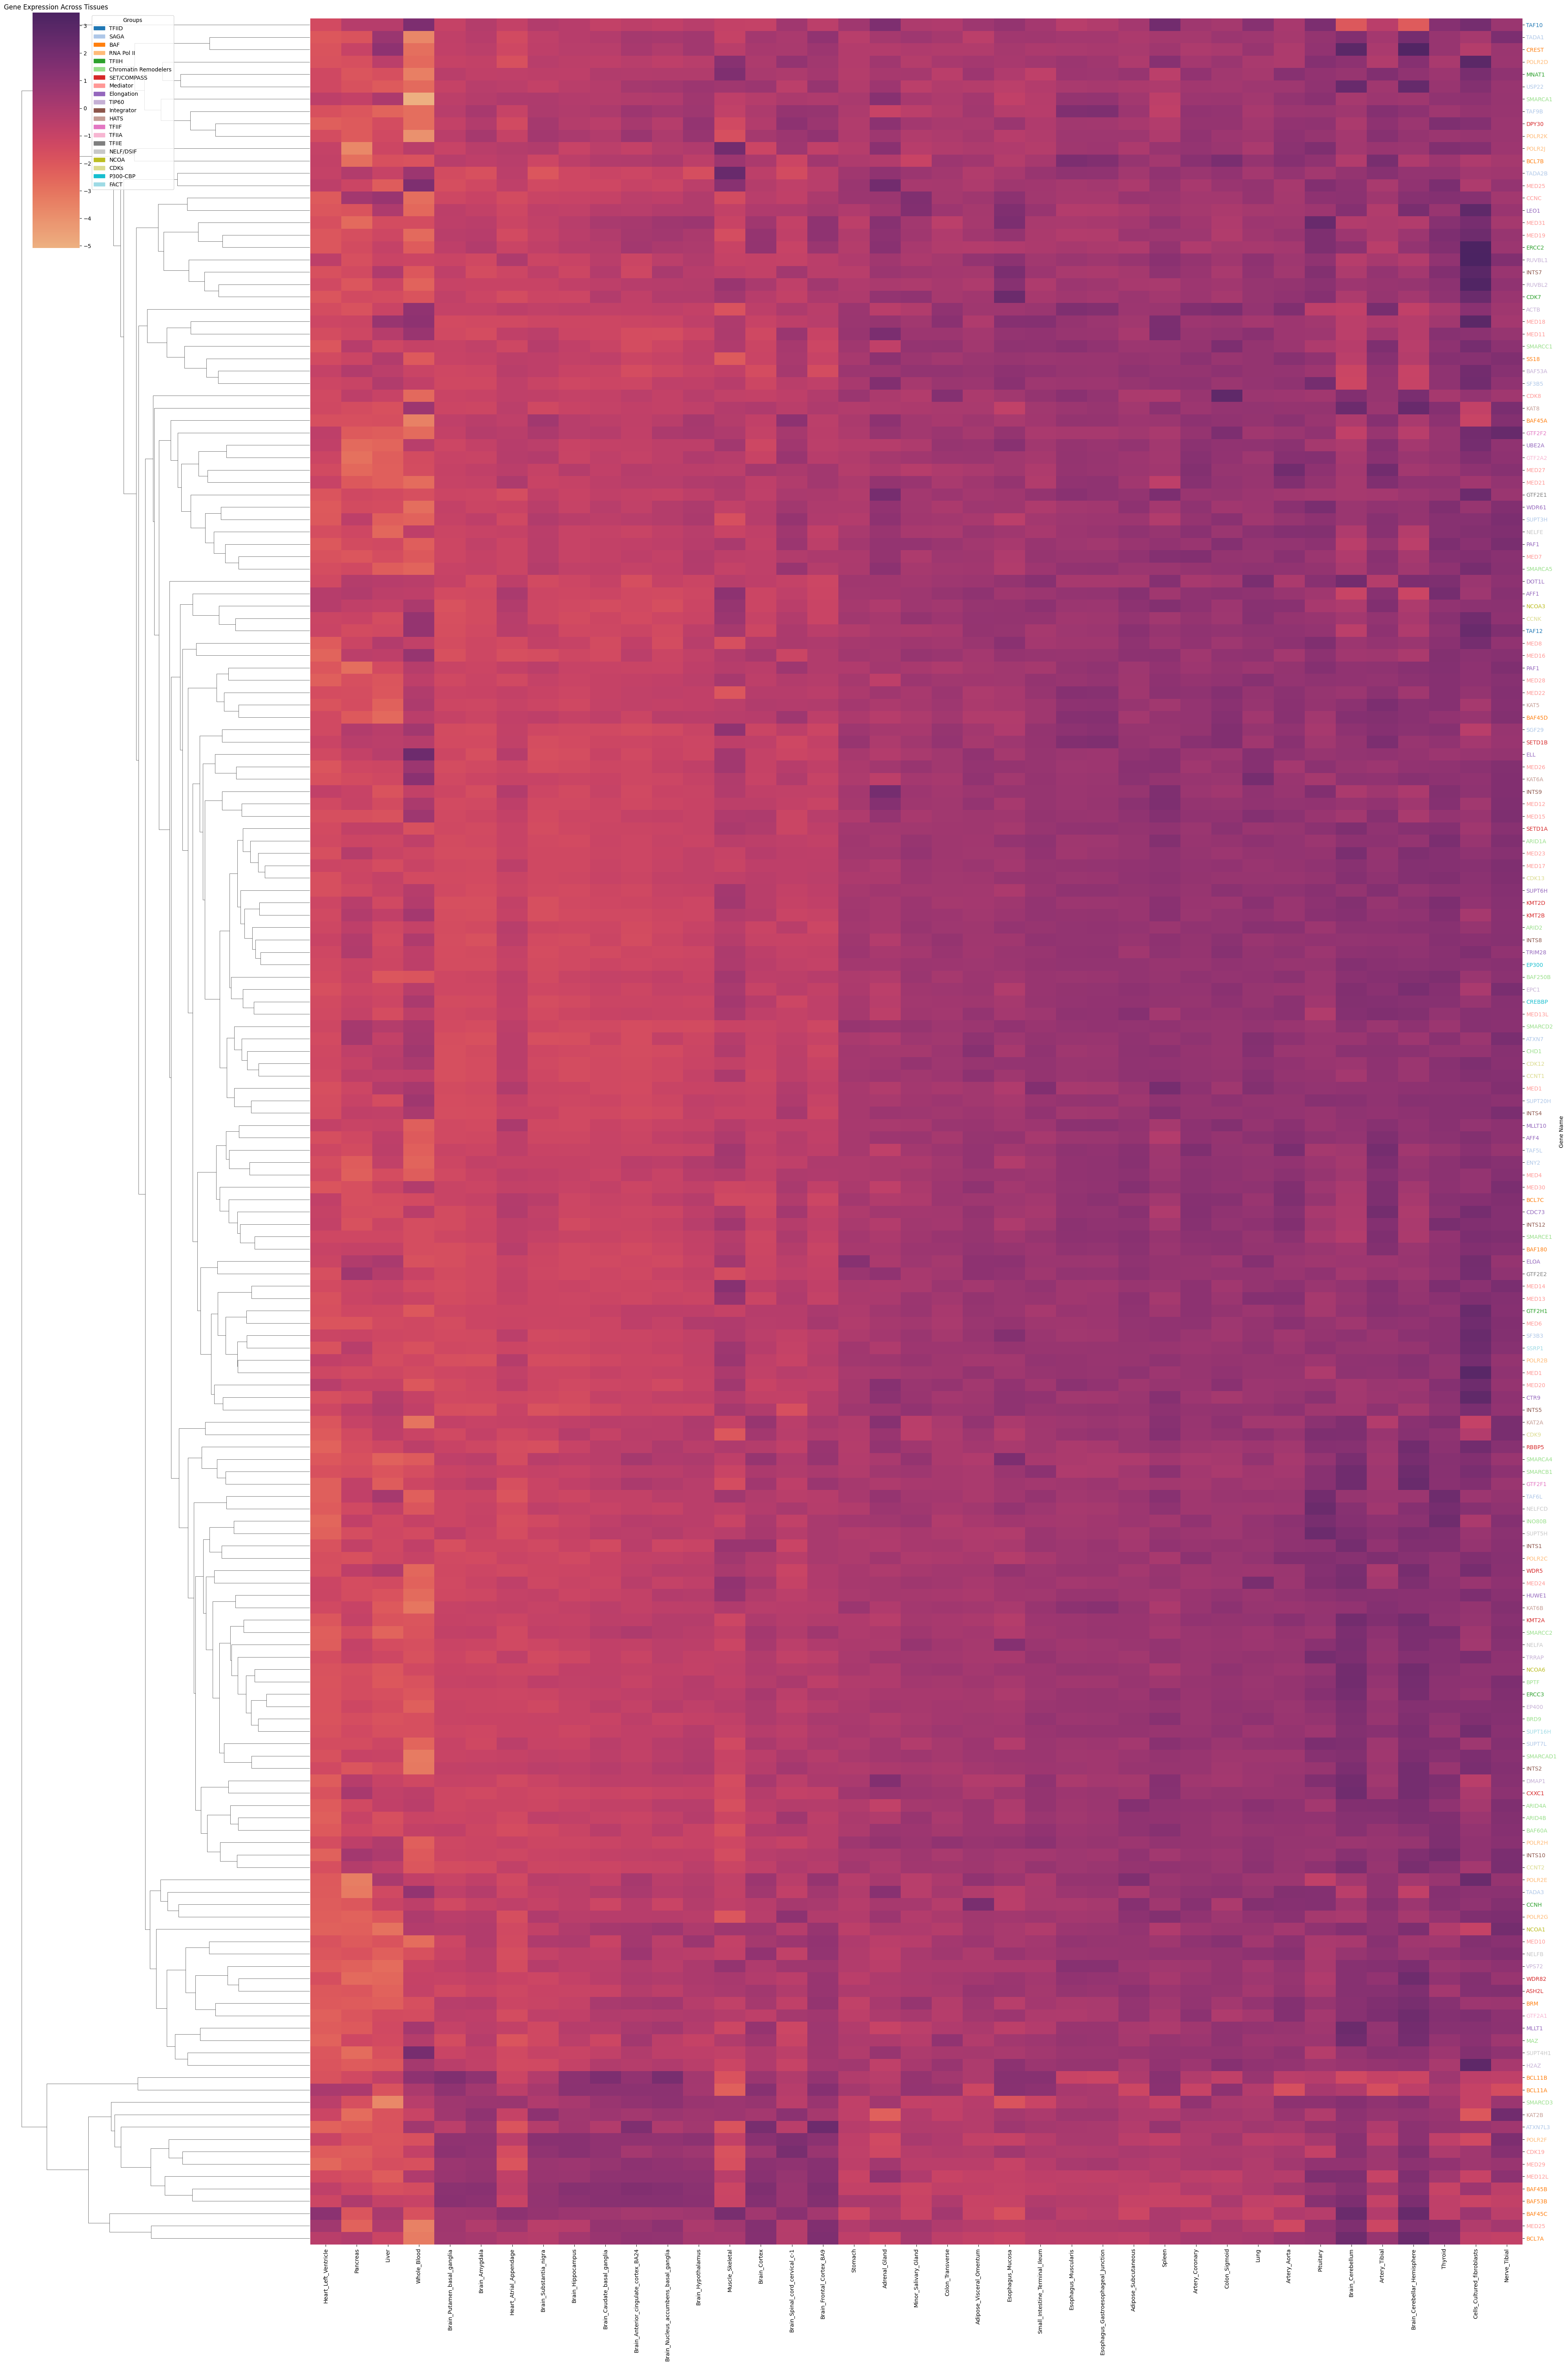

In [14]:
g = sns.clustermap(medians_gene, figsize=(40,60), col_cluster=False, dendrogram_ratio=(.2, 0), cbar_pos=(0.02, 0.9, 0.03, 0.1), cmap = "flare")
plt.title("Gene Expression Across Tissues", loc="center")

#colors y labels by complex
colorpalette = "tab20"
numcolors = len(grouped_single_complex)
color_i = 0
color_dict = {}
for val,label in enumerate(g.ax_heatmap.yaxis.get_majorticklabels()):
    group = get_one_complex(label.get_text())
    if group in color_dict.keys():
        group_label = color_dict[group]
        label.set_color(sns.color_palette(colorpalette)[group_label])
    else:
        label.set_color(sns.color_palette(colorpalette)[color_i])
        color_dict[group] = color_i
        color_i += 1

legend_handles = [mpatches.Patch(color=sns.color_palette(colorpalette)[color], label=group) for group, color in color_dict.items()]
plt.legend(handles=legend_handles, title="Groups", bbox_to_anchor=(1.2, 1), loc='upper left')

plt.show()

g.savefig("figures/normalized/medianexpression_complex.png")

In [40]:
%%script echo
#Make plots for each complex
def makeclustermap(complex):
    grouponly = grouped_single_complex[grouped_single_complex["Complex"] == complex].join(medians_gene).drop("Complex", axis=1)
    g = sns.clustermap(grouponly, figsize=(40, 50), cbar_pos=(0.02, 0.9, 0.03, 0.1), cmap = "flare")
    plt.title("Gene Expression Across Tissues", loc="center")
    g.savefig("figures/normalized/clustercomplex/{0}_medianexpression_complex.png".format(complex.replace("/", "")))

for complex in grouped_single_complex["Complex"].unique():
    makeclustermap(complex)

In [41]:
%%script echo
#Make corr map of each complex
def makecorrmap(complex):
    grouponly = grouped_single_complex[grouped_single_complex["Complex"] == complex].join(medians_gene).drop("Complex", axis=1)
    genecorrelation = grouponly.T.corr()
    plt.figure(figsize=(40,40))
    sns.heatmap(genecorrelation, vmin=-1, vmax=1, cmap = "flare")
    plt.title("Pairwise Correlation Between Gene Expression Across Tissues")
    plt.savefig("figures/normalized/correlationcomplex/{0}_medianexpression_correlation.png".format(complex.replace("/", "")))

for complex in grouped_single_complex["Complex"].unique():
    makecorrmap(complex)

### Measuring Cell-specificity of each Gene

Text(0.5, 1.0, 'Normalized Mean log bulk RNA-seq Across Tissues ()')

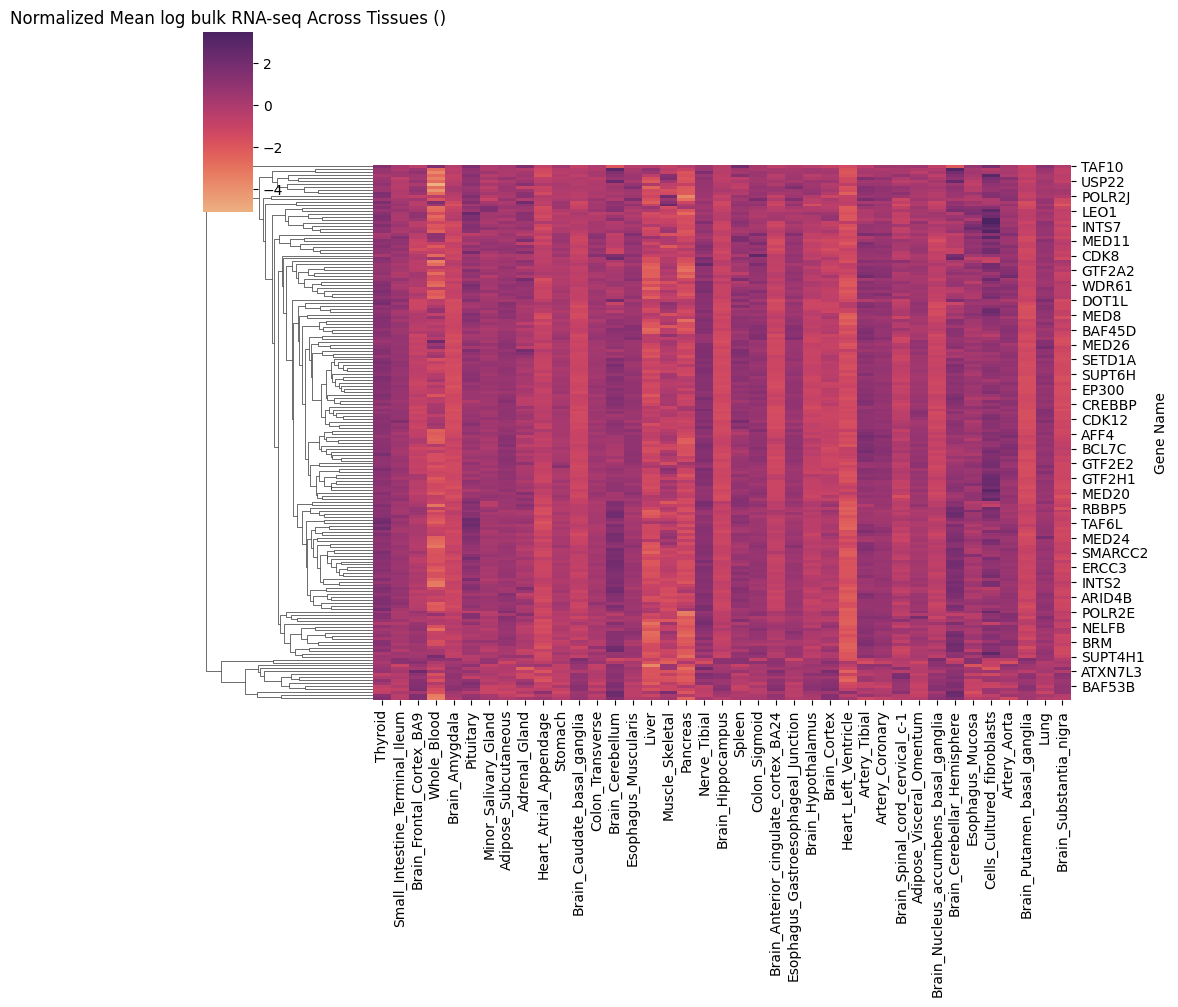

In [ ]:
sns.clustermap(mean_zscore, cmap="flare", col_cluster=False) 
plt.title("Normalized Mean log bulk RNA-seq Across Tissues ()")

<Axes: xlabel='MED12L', ylabel='Count'>

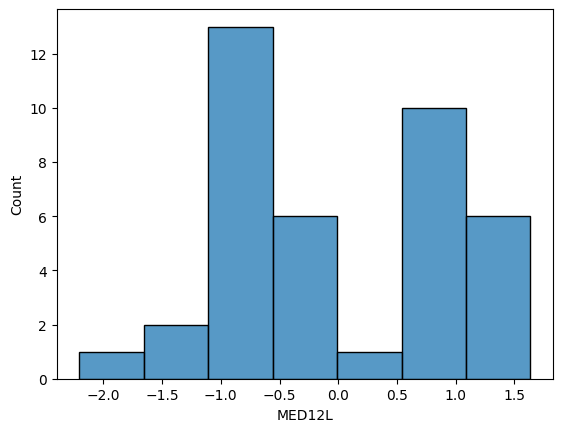

In [19]:
sns.histplot(medians_gene.loc["MED12L"])

In [20]:
medians_gene.head()

,Heart_Left_Ventricle,Pancreas,Liver,Whole_Blood,Brain_Putamen_basal_ganglia,Brain_Amygdala,Heart_Atrial_Appendage,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Colon_Sigmoid,Lung,Artery_Aorta,Pituitary,Brain_Cerebellum,Artery_Tibial,Brain_Cerebellar_Hemisphere,Thyroid,Cells_Cultured_fibroblasts,Nerve_Tibial
Gene Name,,,,,,,,,,,,,,,,,,,,,
POLR2J,-0.885161,-3.707782,-1.225929,-0.485303,-0.973957,-0.484944,-0.331562,-0.195850,-0.983374,-0.553682,...,0.631342,0.034685,1.165636,1.591619,0.286566,0.643983,0.565753,1.520986,1.396771,0.513127
TADA3,-2.135875,-3.232682,-1.396374,0.879286,-0.690558,-0.364463,-1.200305,-0.747207,-0.573727,-0.318817,...,1.080154,0.744660,1.468020,1.406624,-0.529809,0.982902,-0.755882,1.354327,1.132177,1.158430
SMARCB1,-1.739571,-1.602945,-1.901382,-1.575851,-1.037076,-0.873226,-1.025968,-0.890265,-0.997048,-0.673939,...,0.035954,0.398373,0.255880,1.243538,2.112446,0.486949,2.177220,1.237138,1.741245,1.068829
KAT2A,-1.928467,-0.949680,-0.604795,-3.027449,-0.869747,-0.982455,-0.936637,-0.856139,-0.727499,-0.525891,...,1.062249,0.319108,0.309758,1.142073,1.540602,-0.273080,1.196140,1.543365,-0.874869,1.776086
TAF10,-1.457643,-0.371076,-0.389736,1.645340,-0.937334,-0.318751,-0.839048,-0.257157,-0.408861,-0.837241,...,0.206982,1.275483,0.101747,1.685474,-2.052060,-0.531483,-2.148907,1.363328,1.952934,0.605585


# Own-complex Paralogs Correlation

In [21]:
#Clean own-complex paralogs -- fix formatting, rename into the names used in "grouped" df.

def clean_owncomplexparalog(indexcol):
    return [x for x in list(set(grouped["Own-complex paralog"][indexcol])) if pd.notna(x)]

grouped["Own-complex paralog"] = [clean_owncomplexparalog(indexcol) for indexcol in grouped.index.to_list()]
grouped["Has Paralog"] = [len(i) > 0 for i in grouped["Own-complex paralog"]]
has_paralog = grouped[grouped["Has Paralog"] == True]
has_paralog_unique = has_paralog[["Gene Name", "Own-complex paralog"]]
has_paralog_unique["Own-complex paralog"] = has_paralog_unique["Own-complex paralog"].apply(lambda x: x[0].replace("[","").replace("]", "").split(", ")) 

def translate_paralogs(paraloglst):
    paralogtransname = []
    for paralog in paraloglst:
        gtexcode = merged[merged["Gene Name"] == paralog]["GTEXGeneCode"].unique()
        if len(gtexcode) > 0:
            gtexcode = gtexcode[0]
            genename = has_paralog_unique.loc[gtexcode]["Gene Name"]
        else:
            genename = np.NaN
        paralogtransname.append(genename)
    return paralogtransname

has_paralog_unique["Translated Paralogs"] = has_paralog_unique["Own-complex paralog"].apply(translate_paralogs)
has_paralog_unique.head()

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_19980/1381857505.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_paralog_unique["Own-complex paralog"] = has_paralog_unique["Own-complex paralog"].apply(lambda x: x[0].replace("[","").replace("]", "").split(", "))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_19980/1381857505.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_paralog_unique["Translated Paralogs"] = has_paralog_unique["Own-complex paralog"].apply(translate

,Gene Name,Own-complex paralog,Translated Paralogs
GTEXGeneCode,,,
ENSG00000011332.19,BAF45B,[BAF45C],[BAF45C]
ENSG00000049618.22,BAF250B,[BAF250A],[ARID1A]
ENSG00000066117.14,BAF60A,[BAF60C],[SMARCD3]
ENSG00000080503.22,BRM,[BRG1],[SMARCA4]
ENSG00000082014.16,SMARCD3,[BAF60A],[BAF60A]


In [22]:
has_paralog_medians = medians_gene.loc[has_paralog_unique["Gene Name"]]
allparalogpairs = has_paralog_unique.explode("Translated Paralogs")[["Gene Name", "Translated Paralogs"]]

allparalogpairs.head()

,Gene Name,Translated Paralogs
GTEXGeneCode,,
ENSG00000011332.19,BAF45B,BAF45C
ENSG00000049618.22,BAF250B,ARID1A
ENSG00000066117.14,BAF60A,SMARCD3
ENSG00000080503.22,BRM,SMARCA4
ENSG00000082014.16,SMARCD3,BAF60A


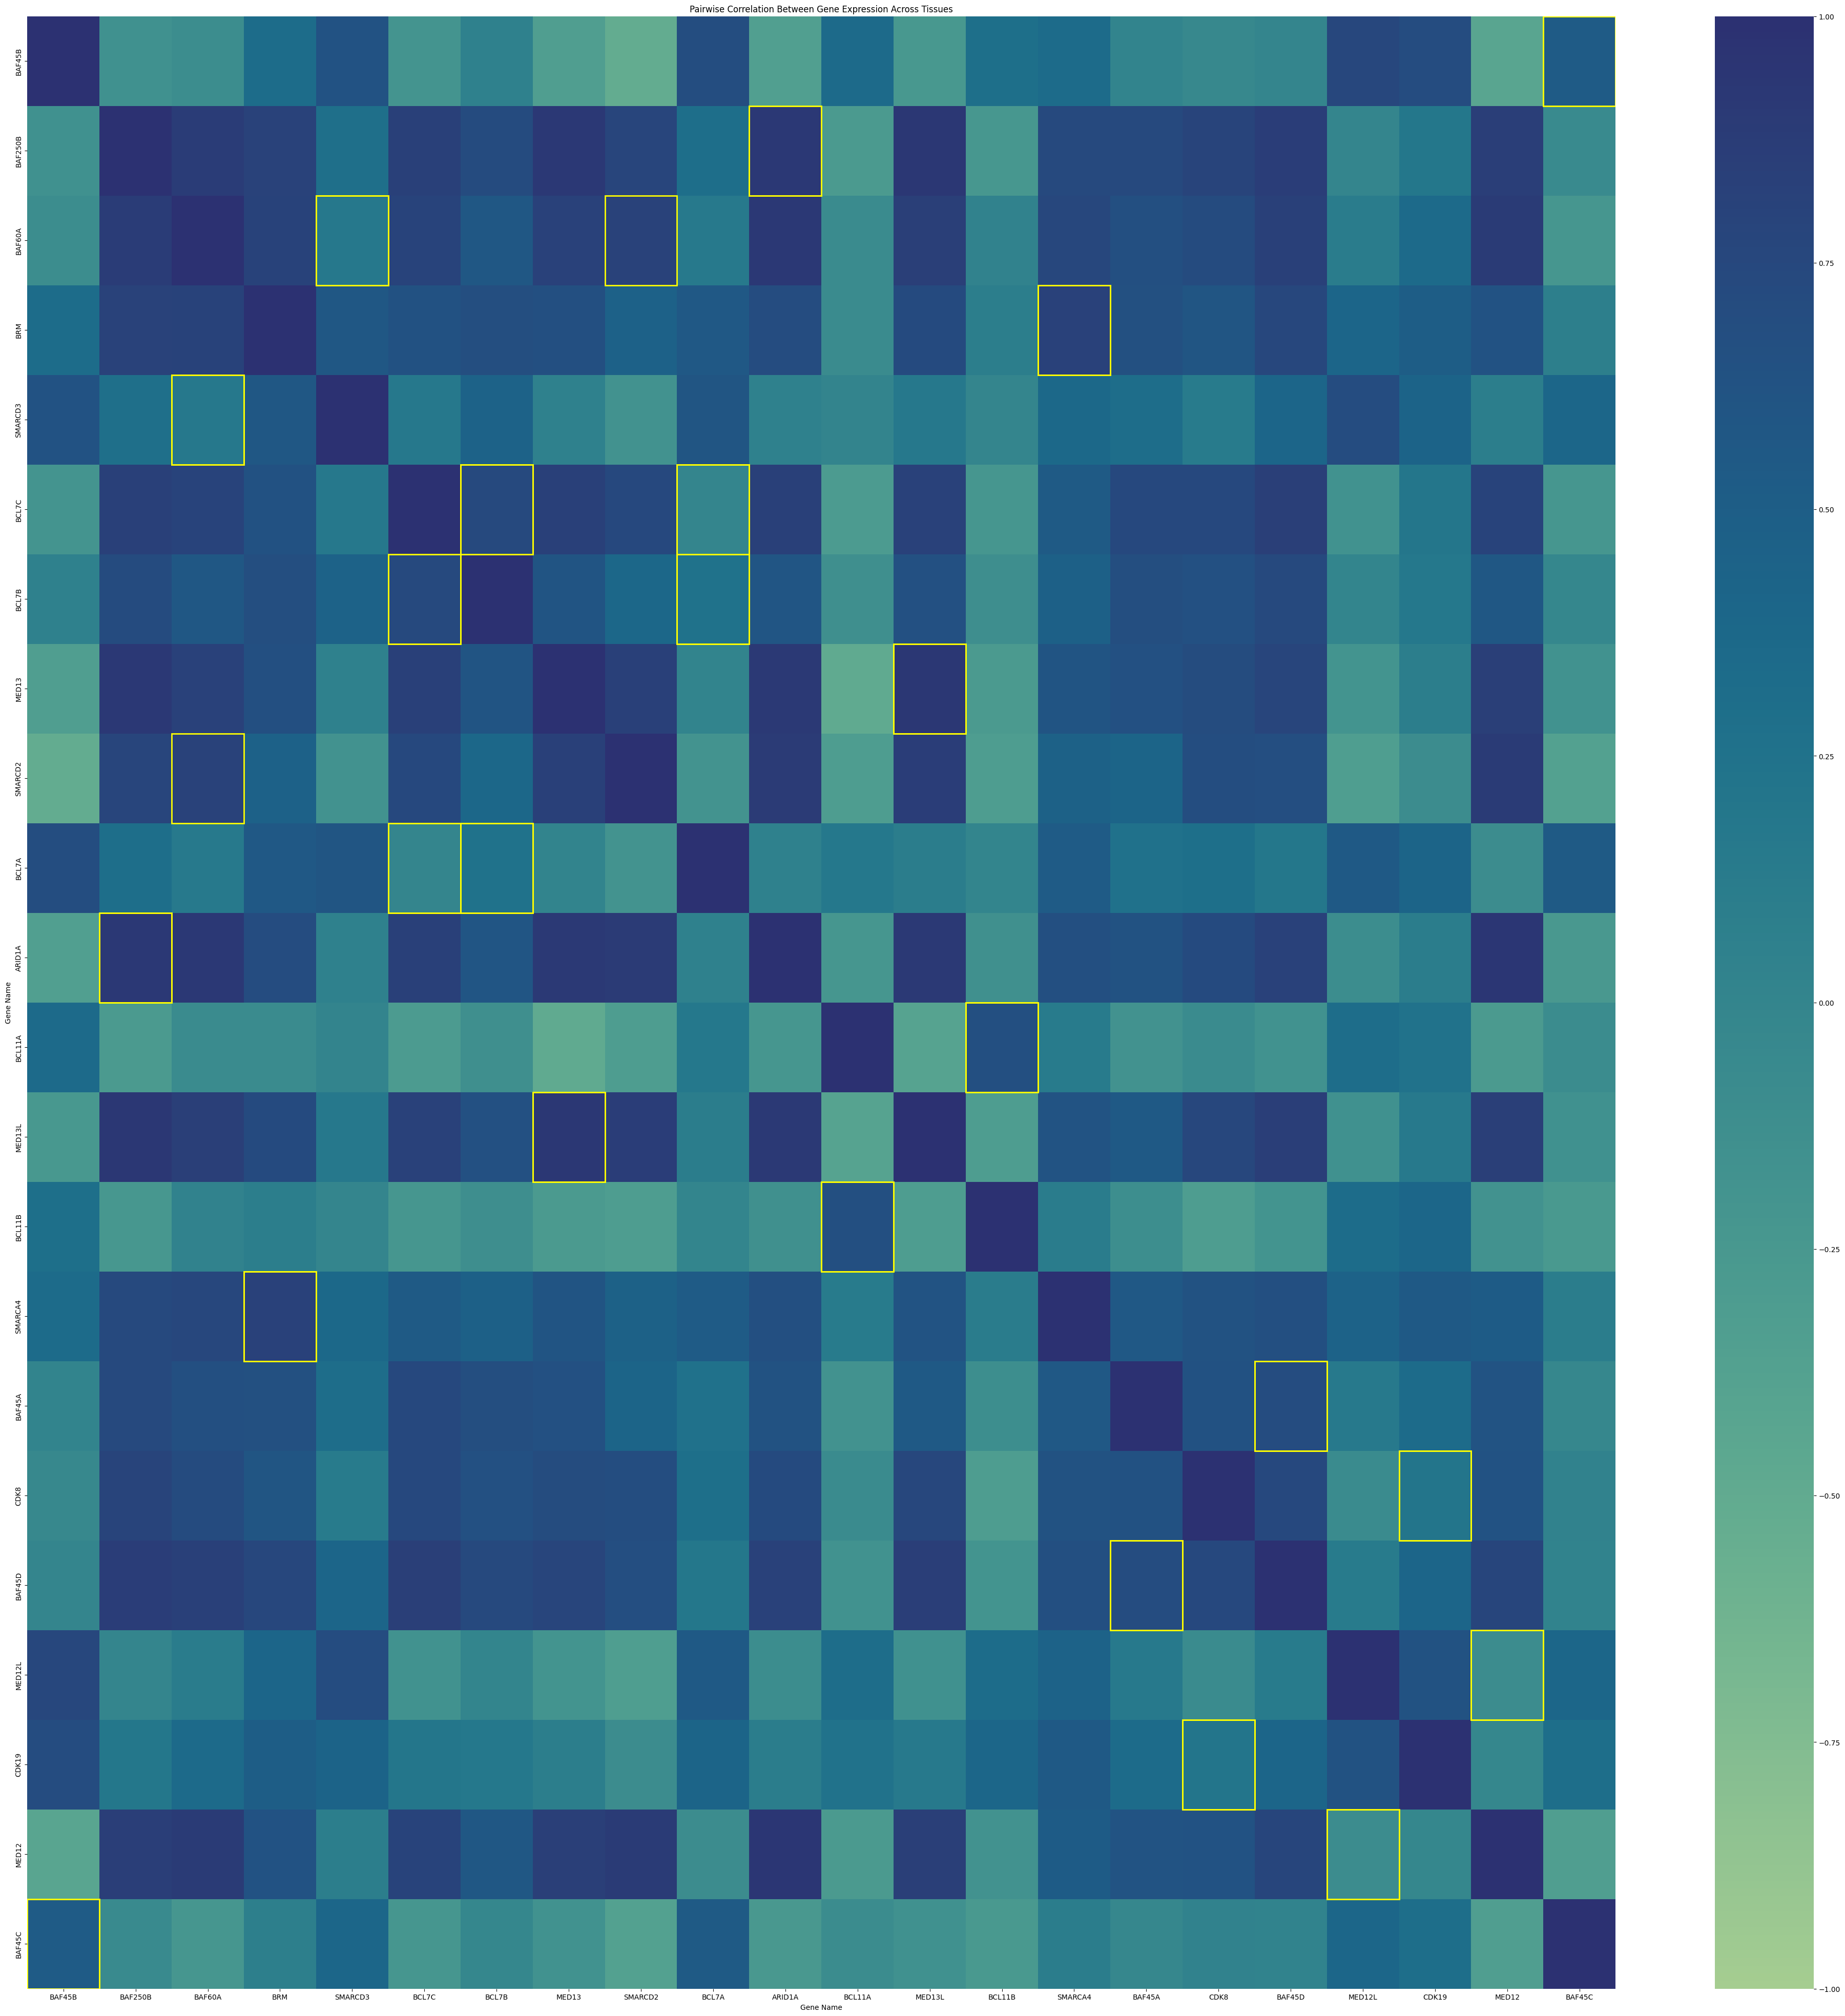

In [23]:
#Correlation heat map for paralogs, colored = paralogoues
has_paralog_medians = medians_gene.loc[has_paralog_unique["Gene Name"]]

paralog_corrs = has_paralog_medians.T.corr()
plt.figure(figsize=(50, 50))
ax = sns.heatmap(paralog_corrs, vmin=-1, vmax=1, cmap="crest")

paralog_i_dict = has_paralog_medians.reset_index()["Gene Name"].to_dict()
paralog_i_dict = {v: k for k, v in paralog_i_dict.items()}

allparalogpairs = has_paralog_unique.explode("Translated Paralogs")[["Gene Name", "Translated Paralogs"]]

for i in range(len(allparalogpairs)):
    x = paralog_i_dict[allparalogpairs.iloc[i]["Gene Name"]]
    y = paralog_i_dict[allparalogpairs.iloc[i]["Translated Paralogs"]]
    ax.add_patch(patches.Rectangle((x, y), 1, 1, linewidth=2, edgecolor='yellow', facecolor='none'))
    ax.add_patch(patches.Rectangle((y, x), 1, 1, linewidth=2, edgecolor='yellow', facecolor='none'))

plt.title("Pairwise Correlation Between Gene Expression Across Tissues")
plt.savefig("figures/normalized/paralog_geneexpressioncorrelation.png")

In [24]:
#Get all pairwise correlations

genecorrelation = medians_gene.T.corr()
correlation_flat = pd.DataFrame(genecorrelation.stack())
correlation_flat.index.names = ["Gene A", "Gene B"]
correlation_flat = correlation_flat.reset_index().drop_duplicates()

#Drops self pairs and redundant pairs
correlation_flat = correlation_flat[correlation_flat["Gene A"] != correlation_flat["Gene B"]]
correlation_flat["Pair"] = correlation_flat.apply(lambda row: tuple(sorted([row["Gene A"], row["Gene B"]])), axis=1)
correlation_flat = correlation_flat.drop_duplicates(subset="Pair").drop(columns="Pair")

correlation_flat = correlation_flat.rename({0: "Correlation"}, axis=1)
correlation_flat = correlation_flat.sort_values("Correlation", ascending=False)
correlation_flat.to_csv("helperfiles/pairwisecorrelationmedian.csv")

correlation_flat.head()

,Gene A,Gene B,Correlation
1880,ERCC3,EP400,0.978470
6991,MED17,CDK13,0.977137
26611,MED23,CDK13,0.976178
12219,TRIM28,EP300,0.972623
2679,SUPT6H,EP300,0.972492


In [25]:
#For each for in has_paralgog, look at correlation in expression data

paralog_corrs = pd.DataFrame({"GeneA": [], "GeneB": [], "Corr": []})

for i in range(len(allparalogpairs)):
    row = allparalogpairs.iloc[i]
    genea = row["Gene Name"]
    geneb = row["Translated Paralogs"]
    try:
        corr = np.round(genecorrelation[genea][geneb], 3)
    except:
        corr = np.NaN
        print(genea, geneb)

    paralog_corrs.loc[i] = [genea, geneb, corr]

paralog_corrs.sort_values("Corr", ascending=False)

,GeneA,GeneB,Corr
9,MED13,MED13L,0.931
15,MED13L,MED13,0.931
1,BAF250B,ARID1A,0.928
13,ARID1A,BAF250B,0.928
3,BRM,SMARCA4,0.827
17,SMARCA4,BRM,0.827
10,SMARCD2,BAF60A,0.818
6,BCL7C,BCL7B,0.735
8,BCL7B,BCL7C,0.735
20,BAF45D,BAF45A,0.701


In [26]:
#Check if genes are from the same complex
corr_mapper = merged.groupby("Gene Name").agg(list)[["Complex", "Subcomplex or Module"]]

def get_complex(genename):
    complexlist = corr_mapper.loc[genename]["Complex"]
    if len(complexlist) == 1:
        return complexlist[0]
    else:
        return complexlist

correlation_flat["Gene A complex"] = correlation_flat["Gene A"].apply(get_complex)
correlation_flat["Gene B complex"] = correlation_flat["Gene B"].apply(get_complex)

def samecomplex(a, b):
    if isinstance(a, str) and isinstance(b, str):
        return (a == b)
    elif isinstance(a, list):
        return b in a
    elif isinstance(b, list):
        return a in b
    

correlation_flat["Same Complex"] = correlation_flat.apply(lambda row: samecomplex(row["Gene A complex"], row["Gene B complex"]), axis=1)
correlation_flat.head()

,Gene A,Gene B,Correlation,Gene A complex,Gene B complex,Same Complex
1880,ERCC3,EP400,0.978470,TFIIH,"[TIP60, HATS]",False
6991,MED17,CDK13,0.977137,Mediator,CDKs,False
26611,MED23,CDK13,0.976178,Mediator,CDKs,False
12219,TRIM28,EP300,0.972623,Elongation,P300-CBP,False
2679,SUPT6H,EP300,0.972492,Elongation,P300-CBP,False


In [27]:
def same_complex_corr(correlationcutoff):
    filteredcorr = correlation_flat[correlation_flat["Correlation"] > correlationcutoff]
    samecomplex = filteredcorr[filteredcorr["Same Complex"] == True]
    return np.round(len(samecomplex)/len(filteredcorr), 5), len(samecomplex), len(filteredcorr)


samecomplex = pd.DataFrame({"Cufoff": np.arange(0.5, 1, 0.05)})
samecomplex["Fraction Same"], samecomplex["Num Same"], samecomplex["Num Diff"]= zip(*samecomplex["Cufoff"].apply(same_complex_corr))

samecomplex.sort_values("Cufoff", ascending=False)

,Cufoff,Fraction Same,Num Same,Num Diff
9,0.95,0.09639,8,83
8,0.90,0.08991,82,912
7,0.85,0.09055,231,2551
6,0.80,0.08463,381,4502
5,0.75,0.08118,529,6516
4,0.70,0.08280,676,8164
3,0.65,0.08231,785,9537
2,0.60,0.08230,878,10668
1,0.55,0.08175,942,11523
0,0.50,0.08180,994,12151


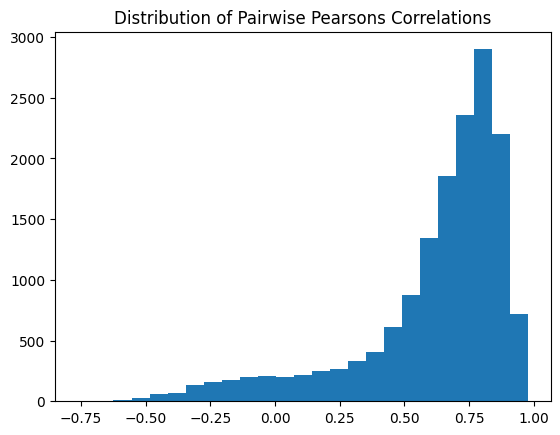

In [28]:
plt.hist(correlation_flat["Correlation"], bins=25)
plt.title("Distribution of Pairwise Pearsons Correlations")
plt.savefig("figures/normalized/correlationdist.png")

# ML clustering exploration

In [29]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

def aggcluster(data, numcclust):
    aggclust = AgglomerativeClustering(n_clusters=numcclust).fit(data)
    clusteringresults = pd.DataFrame({"Gene Name": medians_gene.index, "clusterID": aggclust.labels_})
    clusteringresults = clusteringresults.merge(grouped, on="Gene Name")
    return clusteringresults

def kmeans(data, numclust):
    kmeans = KMeans(n_clusters=numclust, random_state=0, n_init="auto").fit(data)
    clusteringresults = pd.DataFrame({"Gene Name": medians_gene.index, "clusterID": kmeans.labels_})
    clusteringresults = clusteringresults.merge(grouped, on="Gene Name")
    return clusteringresults

aggclustresults = aggcluster(medians_gene, 15)
kmeansclustresults = kmeans(medians_gene, 15)

In [30]:
medians_complex = medians_gene.merge(grouped, right_on="Gene Name", left_index=True).set_index("Gene Name")
medians_complex.head()

,Heart_Left_Ventricle,Pancreas,Liver,Whole_Blood,Brain_Putamen_basal_ganglia,Brain_Amygdala,Heart_Atrial_Appendage,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Brain_Cerebellum,Artery_Tibial,Brain_Cerebellar_Hemisphere,Thyroid,Cells_Cultured_fibroblasts,Nerve_Tibial,Complex,Subcomplex or Module,Own-complex paralog,Has Paralog
Gene Name,,,,,,,,,,,,,,,,,,,,,
POLR2J,-0.885161,-3.707782,-1.225929,-0.485303,-0.973957,-0.484944,-0.331562,-0.195850,-0.983374,-0.553682,...,0.286566,0.643983,0.565753,1.520986,1.396771,0.513127,[RNA Pol II],[],[],False
TADA3,-2.135875,-3.232682,-1.396374,0.879286,-0.690558,-0.364463,-1.200305,-0.747207,-0.573727,-0.318817,...,-0.529809,0.982902,-0.755882,1.354327,1.132177,1.158430,[SAGA],[HAT],[],False
SMARCB1,-1.739571,-1.602945,-1.901382,-1.575851,-1.037076,-0.873226,-1.025968,-0.890265,-0.997048,-0.673939,...,2.112446,0.486949,2.177220,1.237138,1.741245,1.068829,"[BAF, Chromatin Remodelers]","[npBAF, nBAF, esBAF]",[],False
KAT2A,-1.928467,-0.949680,-0.604795,-3.027449,-0.869747,-0.982455,-0.936637,-0.856139,-0.727499,-0.525891,...,1.540602,-0.273080,1.196140,1.543365,-0.874869,1.776086,"[SAGA, HATS]",[HAT],[],False
TAF10,-1.457643,-0.371076,-0.389736,1.645340,-0.937334,-0.318751,-0.839048,-0.257157,-0.408861,-0.837241,...,-2.052060,-0.531483,-2.148907,1.363328,1.952934,0.605585,"[SAGA, TFIID]","[Core, TAF]",[],False


### BAF Complex Proteins in Brain

In [31]:
brainlabels = [x for x in medians_gene.columns.to_list() if "Brain" in x]
BAF_only = medians_complex[["BAF" in x for x in medians_complex["Complex"]]]
BAF_brain = BAF_only[brainlabels]
BAF_brain.head()

,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,Brain_Anterior_cingulate_cortex_BA24,Brain_Nucleus_accumbens_basal_ganglia,Brain_Hypothalamus,Brain_Cortex,Brain_Spinal_cord_cervical_c-1,Brain_Frontal_Cortex_BA9,Brain_Cerebellum,Brain_Cerebellar_Hemisphere
Gene Name,,,,,,,,,,,,,
SMARCB1,-1.037076,-0.873226,-0.890265,-0.997048,-0.673939,-0.490950,-0.500802,-0.297570,-0.008366,-0.221480,0.035124,2.112446,2.177220
BCL7B,-0.450634,-0.643968,-1.174890,-0.577816,-0.262085,-0.229126,-0.015992,-0.575703,0.009640,-1.148083,0.391170,-0.242379,-0.132693
BRM,-0.465394,-0.388358,-1.042693,-0.887811,0.069011,0.173235,0.295247,-0.376031,0.191902,-0.712793,0.808732,1.233086,1.807735
SMARCD2,-1.469649,-1.560469,-1.293429,-1.410375,-1.383078,-1.560919,-1.457715,-1.494982,-1.060933,-0.893039,-1.255614,1.115148,1.056219
SMARCE1,-1.266585,-1.112909,-0.879164,-1.065027,-1.054673,-1.214007,-1.049993,-0.813863,-1.266533,-0.044545,-0.868052,-0.275840,0.025245


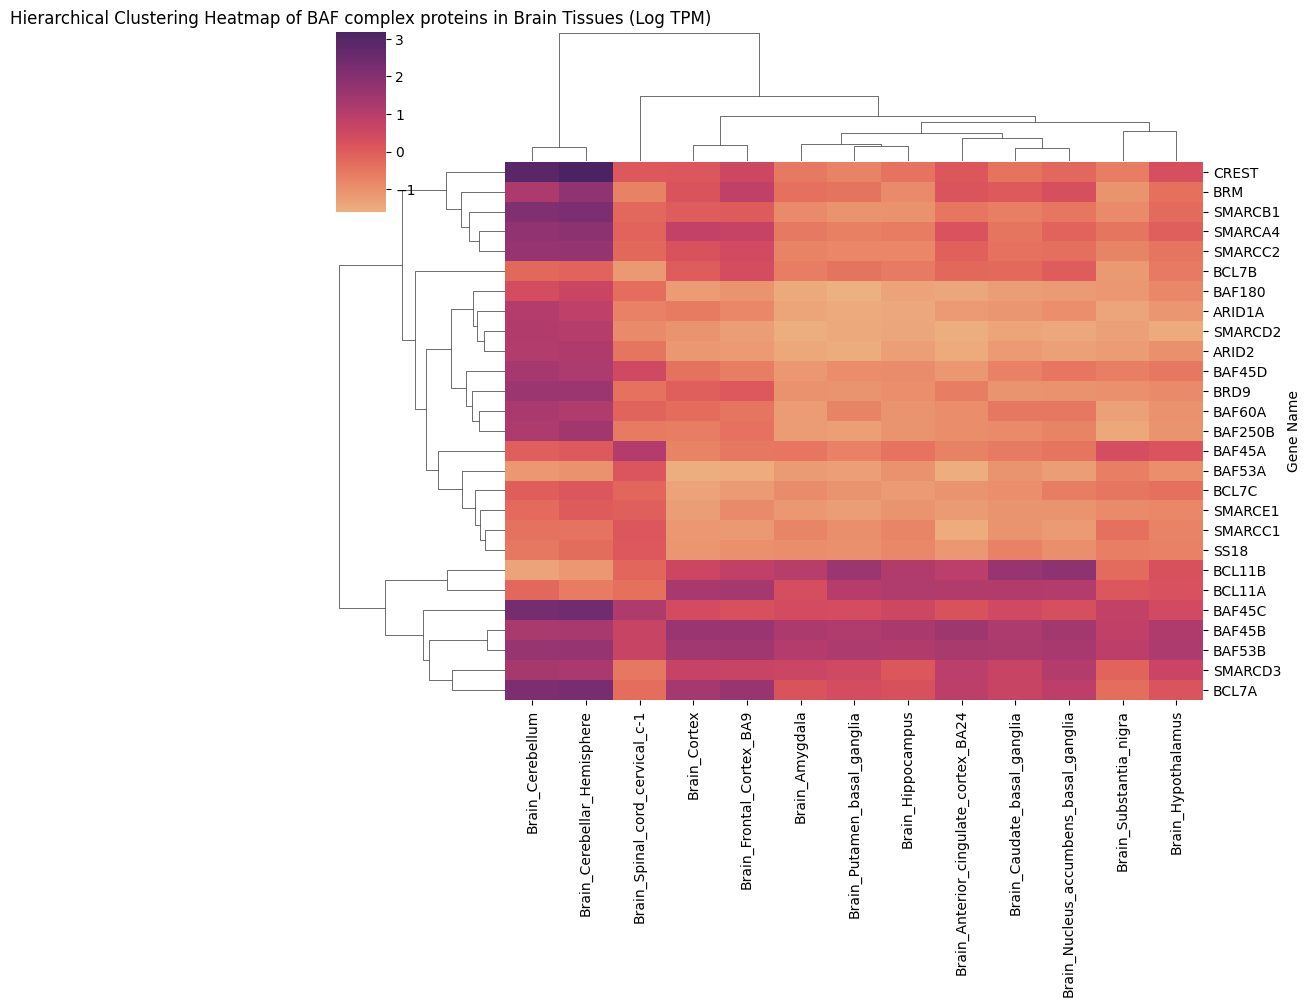

In [34]:
sns.clustermap(BAF_brain, cmap = "flare", figsize=(10, 10))
plt.title("Hierarchical Clustering Heatmap of BAF complex proteins in Brain Tissues (Log TPM)", loc = "center")
plt.savefig("figures/normalized/BAF-brain/bafbrainclustermap.png")

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
brain_PCA = pd.DataFrame(pca.fit_transform(BAF_brain)).rename({0: "PCA1-B", 1:"PCA2-B"}, axis=1)
brain_PCA["Gene Name"] = BAF_brain.index
brain_PCA = brain_PCA.set_index("Gene Name")

brain_PCA.head()

,PCA1-B,PCA2-B
Gene Name,,
SMARCB1,-0.369634,-1.968412
BCL7B,-0.164107,1.321511
BRM,0.863261,-0.941529
SMARCD2,-3.235540,-0.755881
SMARCE1,-2.472124,1.110588


In [37]:
BAF_only = medians_complex[["BAF" in x for x in medians_complex["Complex"]]]
nobrainlabels = [x for x in medians_gene.columns.to_list() if "Brain" not in x]
BAF_nobrain = BAF_only[nobrainlabels]

pca = PCA(n_components=2)
nobrain_PCA = pd.DataFrame(pca.fit_transform(BAF_nobrain)).rename({0: "PCA1-NB", 1:"PCA2-NB"}, axis=1)
nobrain_PCA["Gene Name"] = BAF_nobrain.index
nobrain_PCA = nobrain_PCA.set_index("Gene Name")

nobrain_PCA.head()

,PCA1-NB,PCA2-NB
Gene Name,,
SMARCB1,-0.492324,0.845713
BCL7B,-0.752864,-2.656940
BRM,-0.696649,-1.111562
SMARCD2,-1.327035,1.812901
SMARCE1,-2.240166,-0.475222


<Axes: ylabel='Gene Name'>

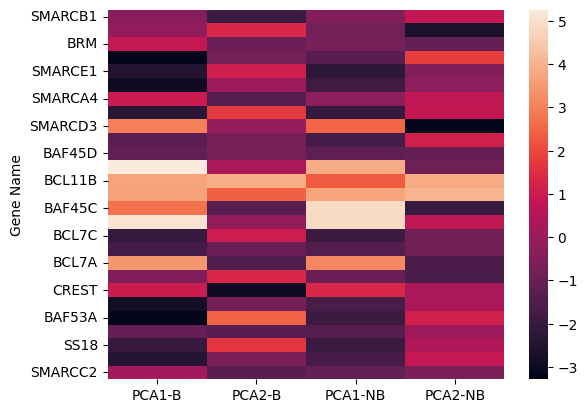

In [38]:
braionconcat = brain_PCA.merge(nobrain_PCA, left_index=True, right_index=True)
sns.heatmap(braionconcat)

In [39]:
medians_gene.columns.to_list()

['Heart_Left_Ventricle',
 'Pancreas',
 'Liver',
 'Whole_Blood',
 'Brain_Putamen_basal_ganglia',
 'Brain_Amygdala',
 'Heart_Atrial_Appendage',
 'Brain_Substantia_nigra',
 'Brain_Hippocampus',
 'Brain_Caudate_basal_ganglia',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Hypothalamus',
 'Muscle_Skeletal',
 'Brain_Cortex',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Frontal_Cortex_BA9',
 'Stomach',
 'Adrenal_Gland',
 'Minor_Salivary_Gland',
 'Colon_Transverse',
 'Adipose_Visceral_Omentum',
 'Esophagus_Mucosa',
 'Small_Intestine_Terminal_Ileum',
 'Esophagus_Muscularis',
 'Esophagus_Gastroesophageal_Junction',
 'Adipose_Subcutaneous',
 'Spleen',
 'Artery_Coronary',
 'Colon_Sigmoid',
 'Lung',
 'Artery_Aorta',
 'Pituitary',
 'Brain_Cerebellum',
 'Artery_Tibial',
 'Brain_Cerebellar_Hemisphere',
 'Thyroid',
 'Cells_Cultured_fibroblasts',
 'Nerve_Tibial']